# Example of GLM implementation in Theano

In [1]:
import numpy as np
import theano.tensor as T
import theano
import matplotlib.pyplot as plt
% matplotlib inline

/Users/pavanramkumar/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(labelsize=14)

### Simulate a regression problem

In [3]:
N = 1000
p = 20

In [4]:
from sklearn.datasets import make_regression
D = dict()
D['X'], D['y'] = make_regression(n_samples=N, 
                                 n_features=p, 
                                 n_informative=p, 
                                 bias=0.2,
                                 noise=0.0)

from sklearn.preprocessing import StandardScaler
D['y'] = StandardScaler().fit_transform(D['y'])

from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(D['X'], D['y'], test_size=0.5)

/Users/pavanramkumar/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/pavanramkumar/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


### Implement the GLM with symbolic tensor manipulations

In [5]:
# Symbolic inputs
X = T.dmatrix('X')
y = T.dvector('y')

In [6]:
# Parameters as shared variables
beta = theano.shared(1/(np.float(p)+1) * np.random.randn(p), name='beta')
beta0 = theano.shared(0., name='beta0')

In [7]:
# Construct Theano expression graph
reg_lambda = theano.shared(0.0, name='reg_lambda')
alpha = theano.shared(0.1, name='alpha')

# Compute the prediction
yhat = beta0 + T.dot(X, beta)

# Define the mean square error loss
loss = T.mean((y - yhat) ** 2) + (1 - alpha) * reg_lambda * T.sum(beta ** 2)

# Compute the gradient of the cost
grad_beta0, grad_beta = T.grad(loss, [beta0, beta])             

In [8]:
# Compile
def prox(b, l):
    """Proximal operator."""
    return T.sgn(b) * (T.abs_(b) - l) * T.le(l, T.abs_(b))

fit = theano.function(
          inputs=[X,y],
          outputs=[yhat, loss],
          updates=((beta0, beta0 - 0.01 * grad_beta0), (beta, prox(beta - 0.01 * grad_beta, alpha * reg_lambda))))

predict = theano.function(inputs=[X], outputs=yhat)


### Train the model

In [9]:
# Train
train_err = list()
test_err = list()

max_iter = 1000
for i in range(max_iter):
    ytrain_hat, err = fit(Xtrain, ytrain)
    train_err.append(np.mean((ytrain - ytrain_hat) ** 2))
    ytest_hat = predict(Xtest)
    test_err.append(np.mean((ytest - ytest_hat) ** 2))

### Evaluate the model

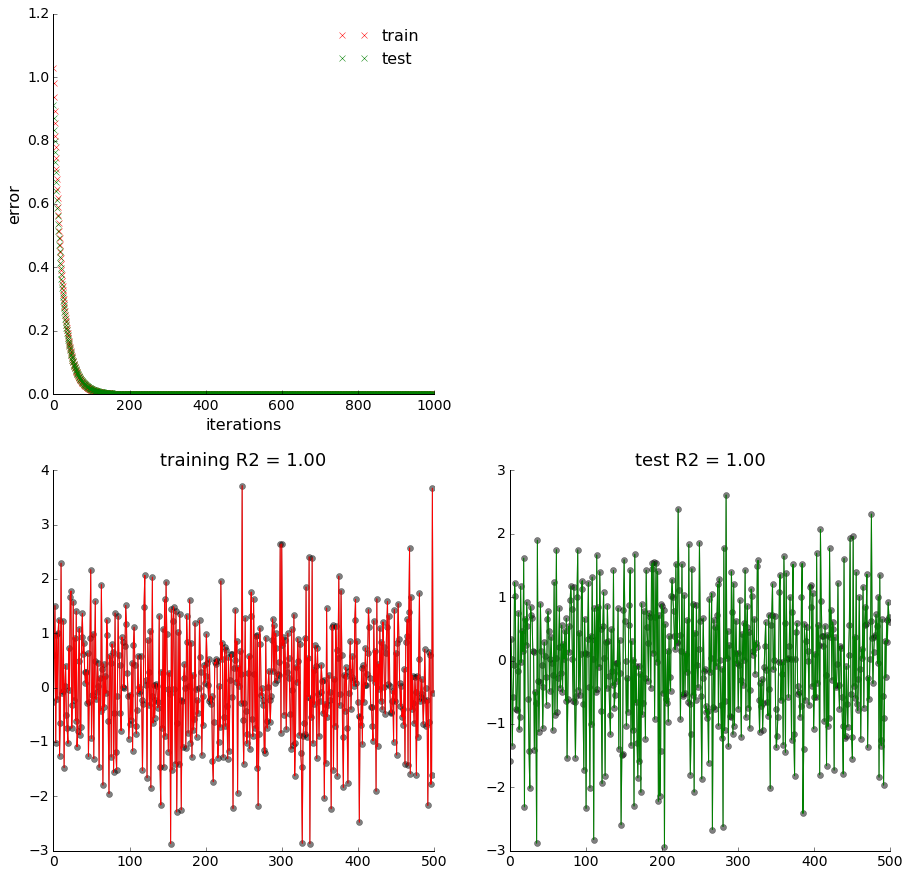

In [10]:
# Visualize training and test error vs. iterations
plt.figure(figsize=(15, 15))
ax = plt.subplot(221)
simpleaxis(ax)
plt.plot(np.arange(max_iter), np.array(train_err), 'rx')
plt.plot(np.arange(max_iter), np.array(test_err), 'gx')
plt.xlabel('iterations', fontsize=16)
plt.ylabel('error', fontsize=16)
plt.legend(['train', 'test'], fontsize=16, frameon=False)

# Training set prediction
ax = plt.subplot(223)
simpleaxis(ax)
ytrain_hat = predict(Xtrain)
R2r = np.corrcoef(ytrain, ytrain_hat)[0,1] ** 2
plt.plot(ytrain, 'ko-', alpha=0.5)
plt.plot(ytrain_hat, 'r')
plt.title("training R2 = %4.2f" % R2r, fontsize=18)

# Test set prediction
ax = plt.subplot(224)
simpleaxis(ax)
ytest_hat = predict(Xtest)
R2t = np.corrcoef(ytest, ytest_hat)[0,1] ** 2
plt.plot(ytest, 'ko-', alpha=0.5)
plt.plot(ytest_hat, 'g')
plt.title("test R2 = %4.2f" % R2t, fontsize=18)

plt.show()